# Multi-Armed Bandits (MABs) and Reinforcement Learning
This is the project for Statistical Machine Learning. In this project, a few reinforcement learning algorithms are implemented and evaluated.

In [1]:
# Change log
# 10/2018 : implement and submit code and project
# 08/2022 : add additonal comments

# only the libraries listed here are permitted to use
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# Special import for KernalUCB
from sklearn.metrics.pairwise import rbf_kernel

## 1. Implement ε-Greedy and UCB

Begin by implementing Python classes EpsGreedy and UCB for both ε-Greedy and UCB learners just as covered in class. You should use inheritance: make your classes sub-classes of the abstract MAB base class. These classes should have components:
- All necessary properties for storing MAB state
- `__init__` constructor methods for initialising MAB state with respective signatures:
    - `def __init__(self, narms, epsilon, Q0)` for positive integer `narms`, floating-point probability `epsilon`, real-valued `Q0` taking by default `numpy.inf`; and
    - `def __init__(self, narms, rho, Q0)` for positive integer `narms`, positive real `rho`, real-valued `Q0` taking by default `numpy.inf`.
- Additional methods (where in your implementations `context` will go unused)
    - `def play(self, tround, context)` for positive integer `tround`, and unused (for now) `context`. This should return an arm integer in `{1, . . . , self.narms}`; and
    - `def update(self, arm, reward, context)` for positive integer `arm` no larger than property `self.narms`, floating-point `reward`, and unused (for now) `context`. This method should not return anything.
    
Tie-breaking in `play()` should be completed uniformly-at-random among value-maximising arms.


In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    # implementation
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        # take care the invalid input
        if epsilon > 1 or epsilon < 0: 
            raise Exception("Epsilon should be between 0 and 1, Invalid Epsilon Value", epsilon)
        elif not float(narms).is_integer():
            raise Exception("Number of arms should be integer, Invalid Number of Arms", narms)
            
        # define variables
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0  
        self.qi = np.ones(narms) * Q0
        self.selects = {}
   
    # implementation    
    def play(self, tround, context=None):
        
        # Exception
        if tround < 0:
            raise Exception('Invalid Round Number', tround)
        
        ep = np.random.rand()  # generate a random number each time in [0,1)
        # explore
        if ep < self.epsilon:
            arm_index = np.random.randint(self.narms)
        # exploit
        else:
            # argmax, tie break randomly
            arm_index =  np.argmax(np.random.random(np.array(self.qi).shape) * (np.array(self.qi)==np.array(self.qi).max()))
        
        arm_no = arm_index + 1  # return the arm integar (1,2,...,10)  
        
        return arm_no
    
    # implementation    
    def update(self, arm, reward, context=None):
    
        # Exception
        if arm > self.narms:
            raise Exception('Invalid Arm Number', arm)
        elif reward != 0 and reward != 1:
            raise Exception('Invalid Reward (0/1)', reward)
        
        arm_index = arm - 1  # change from arm integer to index [0,1,...,9]
        
        # when selecting, add reward to list
        if not bool(arm_index in self.selects):
            self.selects[arm_index] = []
            self.selects[arm_index].append(reward)
        else:
            self.selects[arm_index].append(reward)
        
        # keep qi = q0 if never been selected
        if len(self.selects[arm_index]) == 0:
            pass
        # update qi if being selected
        else:
            average = sum(np.array(self.selects[arm_index]))/len(np.array(self.selects[arm_index])) # miu = (# of 1s)/(# selected)
            self.qi[arm_index] = average # only update the qi for the arm being selected
            
        return
        

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    # implementation
    def __init__(self, narms, rho, Q0=np.inf):
        
        # take care the invalid input
        if not float(narms).is_integer():
            raise Exception("Number of arms should be integer, Invalid Number of Arms", narms)
        elif rho < 0:
            raise Exception('Rho should be positive, Invalid Rho Value', rho)
        
        # define variables
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.qi = np.ones(narms) * Q0
        self.counts = [0 for col in range(narms)]
        self.selects = {}
        
    # implementation
    def play(self, tround, context=None):
        
        # Exception
        if tround < 0:
            raise Exception('Invalid Round Number', tround)
        
        # argmax, tie break randomly
        arm_index =  np.argmax(np.random.random(np.array(self.qi).shape) * (np.array(self.qi)==np.array(self.qi).max()))
        arm_no = arm_index + 1 # change from index (0,1,...,9) to arm number (1,2,...,10)
        return arm_no
        
    # implementation
    def update(self, arm, reward, context=None):
        
        # Exception
        if arm > self.narms:
            raise Exception('Invalid Arm Number', arm)
        elif reward != 0 and reward != 1:
            raise Exception('Invalid Reward (0/1)', reward)
        
        arm_index = arm - 1
        self.counts[arm_index] = self.counts[arm_index] + 1 # store the number of times selected for each arm
        totalround = sum(self.counts)  # total number of rounds in update(), different from the tround in play()
        
        for each_arm in range(self.narms):
            count_arm = self.counts[each_arm]
            
            # when selecting, add reward to list
            if each_arm == arm_index:
                if not bool(arm_index in self.selects):
                    self.selects[arm_index] = []
                    self.selects[arm_index].append(reward)
                else:
                    self.selects[arm_index].append(reward)
                      
            if count_arm == 0:
                self.qi[each_arm] = self.Q0  # keep qi = initial q0 until being selected    
            else:
                average = sum(np.array(self.selects[each_arm]))/len(np.array(self.selects[each_arm]))  # calculate average reward
                bound = np.sqrt(self.rho * (np.log(float(totalround))) / len(np.array(self.selects[each_arm]))) # upper bound
                self.qi[each_arm] = average + bound  # update every qi, not only the one being selected
     
        return
    

## 2. Off-Policy Evaluation

In this part you are to implement a Python function for offline/off-policy evaluation. You must implement the algorithm first described as Algorithm 3 “Policy Evaluator” from the paper:

- Lihong Li, Wei Chu, John Langford, Robert E. Schapire, ‘A Contextual-Bandit Approach to Personalized News Article Recommendation’, in *Proceedings of the Nineteenth International Conference on World Wide Web (WWW 2010)*, Raleigh, NC, USA, 2010. https://arxiv.org/pdf/1003.0146.pdf
- Lihong Li, Wei Chu, John Langford, and Xuanhui Wang. ‘Unbiased offline evaluation of contextualbandit-based news article recommendation algorithms.’ In *Proceedings of the Fourth ACM International Conference on Web Search and Data Mining (WSDM’2011)*, pp. 297-306. ACM, 2011.
https://arxiv.org/pdf/1003.5956.pdf

Implement your function (nominally outside any Python class) with signature

- `def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None)` for a MAB class object `mab` such as `EpsGreedy`, `UCB` (and the classes implemented in later project Parts), a (numpy) array `arms` of values in `{1, . . . , mab.narms}`, an array of scalar numeric `rewards` of the same length as `arms`, a numeric 2D array `contexts` with number of rows equal to the length of `arms` and number of columns equal to a positive multiple of `mab.narms`, a positive integer `nrounds` with default value `None`. 

**Dataset:** The file `dataset.txt` has the following format:
- 10,000 lines (i.e., rows) corresponding to distinct site visits by users—events in the language of this part;
- Each row comprises 102 space-delimited columns of integers:
    - Column 1: The arm played by a uniformly-random policy out of 10 arms (news articles);
    - Column 2: The reward received from the arm played—1 if the user clicked 0 otherwise; and
    - Columns 3–102: The 100-dim flattened context: 10 features per arm (incorporating the content of the article and its match with the visiting user), first the features for arm 1, then arm 2, etc. up to arm 10.

Your function should be able to run on this file where column 1 forms `arms`, column 2 forms `rewards`, and columns 3–102 form `contexts`. On both classes you’ve implemented thus far. 


In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    # implementation
    # take care the invalid input
    if nrounds < 0 or not float(nrounds).is_integer():
        raise Exception("Invalid Numbers of Rounds", nrounds)
    elif len(arms) != len(rewards) or len(arms) != len(contexts) or len(rewards) != len(contexts):
        raise Exception("Incomplete data reading, please read the dataset again.")
    
    # intialisation
    tround = 1
    h_update = np.empty((0, np.reshape(arms,(-1,1)).shape[1] + np.reshape(rewards,(-1,1)).shape[1] + contexts.shape[1]))
    OutReward = []
    start_index = []
    start_index.extend([0,0])
     
    # for each event in the log file
    # set a break point each time there is a match, and continue afterwards
    for logno in range(start_index[tround],len(arms)):
        
        # read arm, reward, context for each event
        arm_t = arms[logno]
        reward_t = rewards[logno]
        context_t = contexts[logno]
        
        arm_no = mab.play(tround,context_t) # play for each log event
        
        # check if the arm number matches the log event
        if arm_no != arm_t:
            # if does not match, move to the next event
            pass
        else:
            # if match, call update() function
            mab.update(arm_no, reward_t, context_t)
            
            # add results to the list
            h_i = np.hstack((arm_t,reward_t,context_t)).reshape(1,-1)
            h_update = np.concatenate([h_update,h_i])
            OutReward.append(reward_t)
            start_index.append(logno)
            tround += 1
            
            # return result array after it reaches to the number of target rounds
            if h_update.shape[0] == nrounds:
                return np.array(OutReward)
    
    # if the file finishes before reaching the target rounds, print the message   
    print('Reach to the end of the dataset, results averaging over %d rounds.' %(len(OutReward)))
        
    return np.array(OutReward)


In [6]:
# This code block is used for reading the dataset file
with open('dataset.txt','r') as datafile:
    entries = [line.rstrip('\n') for line in datafile]
    datafile.close()
    
    arms = np.array([int(line.split()[0]) for line in entries])
    rewards = np.array([int(line.split()[1]) for line in entries])
    contexts = [line.split()[2:] for line in entries]
    
    contexts = [int(contexts) for line in contexts for contexts in line]
    contexts = np.reshape(contexts,(int(len(arms)),int(len(contexts)/len(arms)))) # reshape contexts to fit in offlineEvaluate
    

In [7]:
# output the result
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18625


In [8]:
# output the result
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17125


## 3. Contextual Bandits

In this part you are to implement a third MAB learner as a third Python class. This time you are to read up to and including Section 3.1 of the WWW’2010 paper to understand and then implement the LinUCB learner with disjoint linear models (Algorithm 1). This is a contextual bandit—likely the first you’ve seen—however it’s workings are a direct mashup of UCB and ridge regression both of which you’ve seen in class. Practicing reading and implementing papers is the best way to turbo-charge your ML skills. Your class `LinUCB` should have methods

- `def __init__(self, narms, ndims, alpha)` constructor for positive integer `narms` the number of arms, positive integer `ndims` the number of dimensions for each arm’s context, positive real-valued `alpha` a hyperparameter balancing exploration-exploitation
- `def play(self, tround, context)` as for your other classes. For positive integer `tround`, and `context` being a numeric array of length `self.ndims * self.narms`; and
- `def update(self, arm, reward, context)` as for your other classes. For positive integer `arm` no larger than property `self.narms`, floating-point `reward`, and `context` as previous.


In [9]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    # implementation
    def __init__(self, narms, ndims, alpha):
        
        # take care the invalid input
        if not float(narms).is_integer():
            raise Exception("Number of arms should be integer, Invalid Number of Arms", narms)
        elif not float(ndims).is_integer():
            raise Exception("Number of contexts dimensions should be integer, Invalid Number of Dimensions", ndims)
        elif alpha < 0:
            raise Exception('Alpha should be positive, Invalid Alpha Value', alpha)
        
        # define variables
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.aa = {}
        self.aainv = {}
        self.ba = {}
        self.theta = {}
        self.p = np.empty(self.narms)
        self.x_array = np.empty((self.ndims, self.narms))

        # matrix initialisation
        for arm in range(self.narms):
            self.aa[arm] = np.identity(self.ndims)
            self.ba[arm] = np.zeros((self.ndims,1))
       
    # implementation    
    def play(self, tround, context):
        
        # Exception
        if tround < 0:
            raise Exception('Invalid Round Number', tround)
        
        # reshape context array to form a matrix
        self.x_array = np.transpose(np.reshape(context, (self.narms, self.ndims)))
        
        # calculate theta_a and p for each arm, using the contexts
        # calculate every event, not only the matching ones
        for a in range(self.narms):
            self.aainv[a] = inv(self.aa[a])
            self.theta[a] = np.matmul(self.aainv[a], self.ba[a])
            x_array_a = self.x_array[:,a]
            pa = self.theta[a].T @ x_array_a + self.alpha * (np.sqrt(x_array_a.T @ self.aainv[a] @ x_array_a))
            self.p[a] = pa
        
        # play an arm, argmax, tie break randomly
        arm_index =  np.argmax(np.random.random(np.array(self.p).shape) * (np.array(self.p)==np.array(self.p).max()))
        arm_no = arm_index + 1
        
        return arm_no
    
    # implementation    
    def update(self, arm, reward, context): 
        
        # Exception
        if arm > self.narms:
            raise Exception('Invalid Arm Number', arm)
        elif reward != 0 and reward != 1:
            raise Exception('Invalid Reward (0/1)', reward)
        
        arm_index = arm - 1
        
        # update Aa and ba for the selected arm, using the contexts
        context_m = self.x_array[:,arm_index]
        self.aa[arm_index] += np.outer(context_m,context_m)
        self.ba[arm_index] += reward * np.reshape(context_m,(self.ndims,1))
        
        return
    

In [10]:
# output the result
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
In this part you are to delve deeper into the performance of your implemented bandit learners. 

### 4.A. Plot the running per-round cumulative reward
Run `offlineEvaluate` on each of your Python classes with hyperparameters as
above. This time plot the running per-round cumulative reward as a function
of round *T*, all on one overlayed plot. 

EpsGreedy average reward (Over 100 iterations) 0.21761250000000001
UCB average reward (Over 100 iterations) 0.15941249999999998
LinUCB average reward 0.53


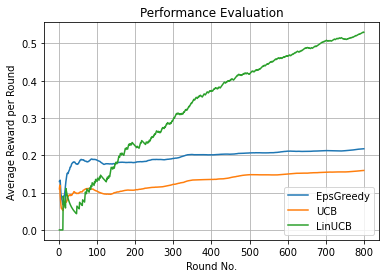

In [11]:
# implementation
# EpsGreedy and UCB, the results change a lot every time because of the randomness
# iterate over 100 runs and calculate the average of the results
IterRound = 100
results_EpsGreedy_Iter = np.zeros((800,IterRound))
results_UCB_Iter = np.zeros((800,IterRound))

for i in range(IterRound):
    mab = EpsGreedy(10, 0.05)
    results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_EpsGreedy_Iter[:,i] = results_EpsGreedy
    
    mab = UCB(10, 1.0)
    results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_UCB_Iter[:,i] = results_UCB
    
print('EpsGreedy average reward (Over 100 iterations)', np.mean(np.mean(results_EpsGreedy_Iter,axis = 1)))
print('UCB average reward (Over 100 iterations)', np.mean(np.mean(results_UCB_Iter,axis = 1)))
print('LinUCB average reward', np.mean(results_LinUCB))


# plot the results
t = np.arange(1,results_EpsGreedy.shape[0]+1)

fig, ax = plt.subplots()
ax.plot(t, np.cumsum(np.mean(results_EpsGreedy_Iter,axis = 1))/t, label='EpsGreedy')
ax.plot(t, np.cumsum(np.mean(results_UCB_Iter,axis = 1))/t, label='UCB')
ax.plot(t, np.cumsum(results_LinUCB)/t, label='LinUCB')  # LinUCB result is stable, no need to calculate average
legend = ax.legend(loc='lower right')
plt.xlabel('Round No.')
plt.ylabel('Average Reward per Round')
plt.title('Performance Evaluation')
plt.grid(True)
plt.show()


Discussion: Unlike the other two methods, LinUCB uses contextual information, the performance achieves a significantly increase compared to EpsGreedy and UCB methods.

### 4.B. Hyperparameters optimisation
How can you optimise hyperparameters? Devise a grid-search based strategy to select the α hyperparameter in LinUCB, as Python code in your notebook. Output the result of this strategy—which could be a graph, number, etc.

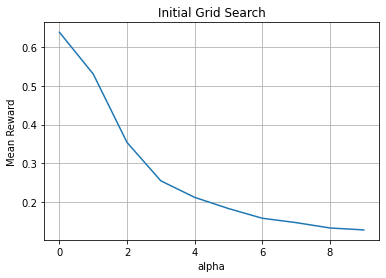

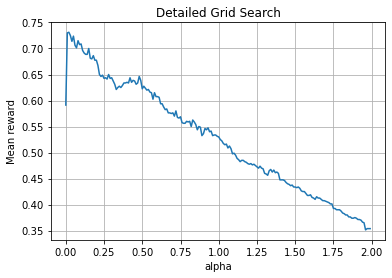

From grid-search, the highest mean reward is 0.73125, the optimal hyperparameter in LinUCB is alpha = 0.02.


In [12]:
# implementation
# initial grid search in the range of [0,10) with the step size = 1
linUCB_grid = []

InitRange = np.arange(0,10,1)
linUCB = np.empty((0,len(InitRange)))

# grid search
for al in InitRange:
    mab = LinUCB(10, 10, al)
    grid = offlineEvaluate(mab, arms, rewards, contexts, 800)
    linUCB_grid.append(np.mean(grid))
   
# plot the results
plt.plot(InitRange,np.array(linUCB_grid))
plt.xlabel('alpha')
plt.ylabel('Mean Reward')
plt.title('Initial Grid Search')
plt.grid(True)
plt.show()


# detailed grid search in the range of [0,2) with the step size = 0.01
# based on the results of initial grid search
linUCB_grid = []
DetaRange = np.arange(0,2,0.01)
linUCB = np.empty((0,len(DetaRange)))

# grid search
for al in DetaRange:
    mab = LinUCB(10, 10, al)
    grid = offlineEvaluate(mab, arms, rewards, contexts, 800)
    linUCB_grid.append(np.mean(grid))
 
# plot the results
plt.plot(DetaRange,np.array(linUCB_grid))
plt.xlabel('alpha')
plt.ylabel('Mean reward')
plt.title('Detailed Grid Search')
plt.grid(True)
plt.show()

print('From grid-search, the highest mean reward is %6.5f, the optimal hyperparameter in LinUCB is alpha = %3.2f.' % (np.max(np.array(linUCB_grid)), DetaRange[np.argmax(np.array(linUCB_grid))]))



## 5. KernelUCB

So far you have built on knowledge of bandits and ridge regression. In this part you would make use of the kernel methods part of class in a mashup of all three concepts by implementing as a fourth Python class the KernelUCB (with online updates) that is Algorithm 1 of this paper:

- Michal Valko, Nathan Korda, R´emi Munos, Ilias Flaounas, and Nello Cristianini, ‘Finite-time analysis of kernelised contextual bandits.’ In *Proceedings of the Twenty-Ninth Conference on Uncertainty in Artificial Intelligence (UAI’13)*, pp. 654-663. AUAI Press, 2013. https://arxiv.org/ftp/arxiv/papers/1309/1309.6869.pdf

Implement sub-class KernelUCB with the following methods

- `def __init__(self, narms, ndims, gamma, eta, kern)` constructor for positive integer `narms` the number of arms, positive integer `ndims` the number of dimensions for each arm’s context, positive realvalued `gamma` and `eta` hyperparameters for regularisation and balancing exploration-exploitation, and `kern` a kernel function from `sklearn.metrics.pairwise`;
- `def play(self, tround, context)` as for `LinUCB`; and
- `def update(self, arm, reward, context)` as for `LinUCB`.

Once done, demonstrate a MAB hyperparameter setting and with choice of the Gaussian/RBF kernel, a plot like in Part 4(a) demonstrating competitive performance relative to LinUCB. Note this kernel is imported for you as `rbf_kernel`. Note also you may try different kernel hyperparameters, and
beware that while the RBF’s parameter is also called ‘gamma’ it is distinct to the ‘gamma’ in KernelUCB.



In [13]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    
    # implementation
    def __init__(self, narms, ndims, gamma, eta, kern):
        
        # take care the invalid input
        if not float(narms).is_integer():
            raise Exception("Number of arms should be integer, Invalid Number of Arms", narms)
        elif not float(ndims).is_integer():
            raise Exception("Number of contexts dimensions should be integer, Invalid Number of Dimensions", ndims)
        elif gamma < 0:
            raise Exception('Gamma should be positive, Invalid Gamma Value', gamma)
        elif eta < 0:
            raise Exception('Eta should be positive, Invalid Eta Value', eta)
        
        # initialisation
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.u = [0.0 for col in range(narms)]
        self.y = []
        self.arm_select = []
        self.arm_select.append(0)
        self.ktinv = {}
        self.context_select = np.empty((0,10))

    # implementation    
    def play(self, tround, context):
        
        # Exception
        if tround < 0:
            raise Exception('Invalid Round Number', tround)
        
        # t = 1, initialise u
        if tround == 1:
            self.u[0] = 1.0
        # calculate and change sigma and u for every event, based on the context
        else:
            reward_array = np.reshape(context,(10,10))
            
            for i in range(self.narms):  # calculate new u for each arm
                xnt = np.reshape(reward_array[i,:],(1,10))
                
                kxn = self.kern(xnt,self.context_select) # kernel mathod
                kxnt = np.transpose(kxn)
                
                # calculate sigma and update u
                sigma = np.sqrt(self.kern(xnt,xnt) - (kxnt.T @ self.ktinv[tround-1] @ kxnt))
                self.u[i] = (kxnt.T @ self.ktinv[tround-1] @ self.y) + (self.eta / np.sqrt(self.gamma)) * sigma
           
        # choose the arm to play, argmax, tie break randomly    
        arm_index =  np.argmax(np.random.random(np.array(self.u).shape) * (np.array(self.u)==np.array(self.u).max()))
        arm_no = arm_index + 1 # change from index to arm number 
        
        return arm_no
    
    # implementation
    def update(self, arm, reward, context):
        
         # Exception
        if arm > self.narms:
            raise Exception('Invalid Arm Number', arm)
        elif reward != 0 and reward != 1:
            raise Exception('Invalid Reward (0/1)', reward)
        
        # add results to the list
        self.arm_select.append(arm)
        tround = len(self.arm_select) - 1
        arm_index = arm - 1
        self.y.append(reward)  # update reward history
        
        # context for the chosen arm
        reward_array = np.reshape(context,(10,10))
        xt = np.reshape(reward_array[arm_index,:],(1,10))
        # construct a matrix to store the contexts
        self.context_select = np.concatenate([self.context_select, xt])
        kxtxt = self.kern(xt,xt)  # kernel method
        
        # calculate Kt^(-1) based on the algorithm
        if tround == 1:
            self.ktinv[tround] = 1/(kxtxt + self.gamma)
        else:
            # kernel method
            kxt = self.kern(xt,self.context_select[:self.context_select.shape[0]-1,:])
            
            # updating
            b = np.transpose(kxt)
            ktinvpre = self.ktinv[tround-1]
            k22 = 1/(kxtxt + self.gamma - (b.T @ ktinvpre @ b))
            k11 = ktinvpre + k22 * (ktinvpre @ b @ b.T @ ktinvpre)
            k12 = -1 * k22 * (ktinvpre @ b)
            k21 = -1 * k22 * (b.T @ ktinvpre)
            
            # building up the matrix
            k1112 = np.concatenate((k11,k12),axis = 1)
            k2122 = np.concatenate((k21,k22),axis = 1)
            kt = np.concatenate((k1112,k2122),axis = 0)
            self.ktinv[tround] = kt   
        
        return      
    

In [14]:
# implementation
# output the result
mab = KernelUCB(10, 10, 1.0, 1.0, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))  

KernelUCB average reward 0.59


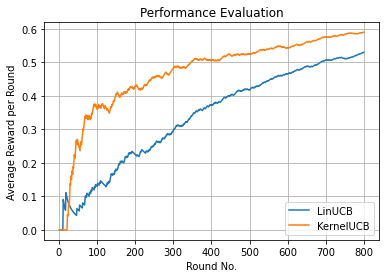

LinUCB average reward 0.53
KernelUCB average reward 0.59


In [15]:
# plot the results, compare KernelUCB with LinUCB
t = np.arange(1,results_LinUCB.shape[0]+1)

fig, ax = plt.subplots()
ax.plot(t, np.cumsum(results_LinUCB)/t, label='LinUCB')  # LinUCB result is stable, no need to calculate average
ax.plot(t, np.cumsum(results_KernelUCB)/t, label='KernelUCB')
legend = ax.legend(loc='lower right')
plt.xlabel('Round No.')
plt.ylabel('Average Reward per Round')
plt.title('Performance Evaluation')
plt.grid(True)
plt.show()


print('LinUCB average reward', np.mean(results_LinUCB))
print('KernelUCB average reward', np.mean(results_KernelUCB))

In [16]:
# use different kernel methods
from sklearn.metrics.pairwise import laplacian_kernel

mab = KernelUCB(10, 10, 1.0, 1.0, laplacian_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))     

KernelUCB average reward 0.675


In [17]:
# use different hyperparameters
from sklearn.metrics.pairwise import laplacian_kernel

mab = KernelUCB(10, 10, 2.0, 1.0, laplacian_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))  

KernelUCB average reward 0.73625


Discussion: For KernelUCB, different kernel methods and different values of hyperparameters will lead to different results. Grid search method can be used for finding the optimal parameter setting.  